In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np
df_GDP=pd.read_csv("Dataset/GDP.csv")
df_INF=pd.read_csv("Dataset/INF.csv")
df_UNEMP=pd.read_csv("Dataset/UNEMP.csv")

In [46]:
# First of all, as i want to perform a 30 year analysis on the 3 datasets (30 years is the best period talking about consistency in these dataset), i need to drop and clean 
dfs=[df_GDP, df_INF, df_UNEMP]

for df in dfs:
    df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'], inplace=True)
    df.set_index('Country Name', inplace=True)

In [47]:
# Only 1993-2024 column filtering
dfs2 = [df_GDP, df_INF, df_UNEMP]
nn_dfs = []
for df in dfs2:
    nn_dfs.append(df.loc[:, df.columns.astype(int) > 1993])

df_GDP, df_INF, df_UNEMP = nn_dfs

# Find intersections
common_index = df_GDP.index.intersection(df_UNEMP.index).intersection(df_INF.index)
filtered_dfs = []
for df in nn_dfs:
    filtered_df = df.loc[common_index] 
    filtered_df.dropna(inplace=True) 
    filtered_dfs.append(filtered_df)

df_GDP_filtered, df_INF_filtered, df_UNEMP_filtered = filtered_dfs

In [48]:
#As i want readable dataframes: convert to billions GDP and only 2 decimals. Way better!

df_GDP_filtered.columns = df_GDP_filtered.columns.astype(int)  
df_GDP_filtered.loc[:, 1994:2023] = df_GDP_filtered.loc[:, 1994:2023] / 1_000_000_000
df_GDP_filtered = df_GDP_filtered.round(2)
df_INF_filtered = df_INF_filtered.round(2)
df_UNEMP_filtered = df_UNEMP_filtered.round(2)

In [49]:
#Now that we achieved a readable dataframe, the best way to work is convert from wide to long format using melt, and the merge to have a all-in-one dataframe.
df_inflation_long = df_INF_filtered.reset_index().melt(id_vars=['Country Name'], var_name='Year', value_name='Inflation')
df_UNEMP_long = df_UNEMP_filtered.reset_index().melt(id_vars=['Country Name'], var_name='Year', value_name='Unemployment')
df_GDP_long = df_GDP_filtered.reset_index().melt(id_vars=['Country Name'], var_name='Year', value_name='GDP')

for df in [df_GDP_long, df_inflation_long, df_UNEMP_long]:
    df["Year"] = df["Year"].astype(int)

df_merged = df_GDP_long.merge(df_inflation_long, on=["Country Name", "Year"], how="inner") \
                  .merge(df_UNEMP_long, on=["Country Name", "Year"], how="inner")

df_merged.set_index('Country Name')
#Way better! This will be good for Tableau!

,Year,GDP,Inflation,Unemployment
Country Name,,,,
Africa Eastern and Southern,1994,243.57,14.85,8.14
Africa Western and Central,1994,134.78,31.84,4.39
Angola,1994,4.44,949.79,17.40
Albania,1994,1.88,22.57,20.84
Arab World,1994,499.88,5.11,13.03
...,...,...,...,...
United States,2023,27720.71,4.12,3.64
St. Vincent and the Grenadines,2023,1.07,4.56,18.57
World,2023,106171.67,5.64,4.92


In [50]:
# Create a Df for a Country. We'll choose Italy
gdp_transposed = df_GDP_filtered.loc['Italy'].T
inf_transposed = df_INF_filtered.loc['Italy'].T
unemp_transposed = df_UNEMP_filtered.loc['Italy'].T

gdp_transposed.index = gdp_transposed.index.astype(str) 
inf_transposed.index = inf_transposed.index.astype(str)
unemp_transposed.index = unemp_transposed.index.astype(str)

df_italy = pd.DataFrame({
    'GDP': gdp_transposed,
    'Inflation': inf_transposed,
    'Unemployment': unemp_transposed
})

df_italy['Year'] = df_italy.index
df_italy.set_index('Year', inplace=True)

In [51]:
#Machine learning: Random Forest Classifier to identify recession from inflation and unemployment.

# Target columns: boolean, 1 if the next GDP is highter, otherwise 0.
df_italy['target'] = (df_italy['GDP'].shift(-1) < df_italy['GDP']).astype(int)
df_italy = df_italy.dropna()

# Trainig and test set
train_data = df_italy[df_italy.index < '2015']
test_data = df_italy[df_italy.index >= '2015']

X_train = train_data[['Unemployment', 'Inflation']]
y_train = train_data['target']
X_test = test_data[['Unemployment', 'Inflation']]
y_test = test_data['target']

# Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

new_data = pd.DataFrame({
    'Unemployment': [df_italy['Unemployment'].loc['2008']], 
    'Inflation': [df_italy['Inflation'].loc['2008']], 
})

prediction = model.predict(new_data)

# Prediction
if prediction == 1:
    print("Recession")
else:
    print("Not a recession")

Recession


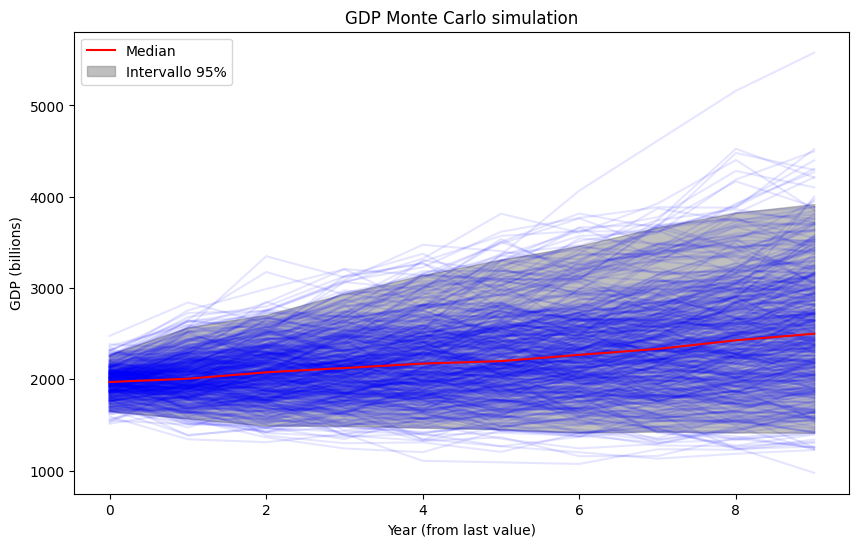

In [54]:
# Growth
df_italy['Growth'] = (df_italy['GDP'].shift(-1) / df_italy['GDP'] - 1) * 100
df_italy = df_italy.dropna()  

# Mean and STD
mu = df_italy['Growth'].mean()
sigma = df_italy['Growth'].std()

# Parameters
years_simulation = 10  
n_simulations = 500  
initial_pil = df_italy['GDP'].iloc[-1] #last value

# Monte carlo simulation
np.random.seed(42)
simulations = np.zeros((n_simulations, years_simulation))
for i in range(n_simulations):
    pil = initial_pil
    for j in range(years_simulation):
        simulated_growth = np.random.normal(mu, sigma) 
        pil *= (1 + simulated_growth / 100) 
        simulations[i, j] = pil

# Interval of confidence
percentili = np.percentile(simulations, [2.5, 50, 97.5], axis=0)

# plotting result
plt.figure(figsize=(10, 6))
plt.plot(simulations.T, color='blue', alpha=0.1)
plt.plot(percentili[1], color='red', label='Median')
plt.fill_between(range(years_simulation), percentili[0], percentili[2], color='gray', alpha=0.5, label='Intervallo 95%')
plt.title('GDP Monte Carlo simulation')
plt.xlabel('Year (from last value)')
plt.ylabel('GDP (billions)')
plt.legend()
plt.show()
